In [1]:
!pip install skorch
#Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib
from joblib import load

#Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#Import Skorch library
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

#Import Sklearn library
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler




#Filter out warnings
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
X_test = pd.read_csv('/content/drive/MyDrive/X_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/y_test.csv')



In [4]:

class MLP(nn.Module):

    def __init__(self, hidden_size, nonlin=F.relu, dropout=0.5):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        

    
    def forward(self, x, **kwargs):
        hidden = self.nonlin(self.fc1(x))
        hidden = self.dropout(hidden)
        hidden = F.relu(self.fc2(hidden))
        out = F.softmax(self.fc3(hidden), dim=1)
        return out
    
mlp = NeuralNetClassifier(MLP)

In [5]:

mlp = load('/content/drive/MyDrive/MLP_optimised.joblib')

In [6]:
X_testTensor = torch.tensor(X_test.to_numpy()).float()
y_testTensor = torch.tensor(y_test.to_numpy()).long()

In [7]:
mlp.score(X_testTensor,y_testTensor)

0.7987012987012987

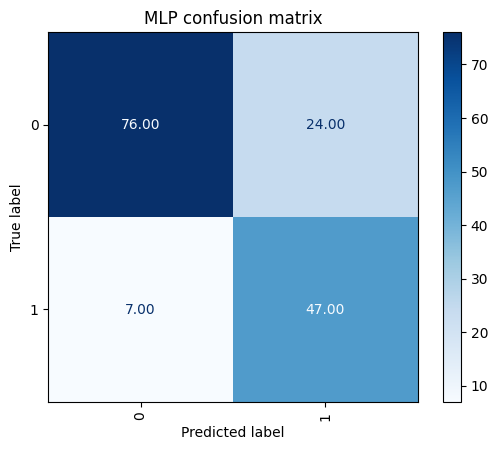

In [8]:
y_pred = mlp.predict(X_testTensor)

#Generate confusion matrix
cm = confusion_matrix(y_testTensor, y_pred)

#Plot normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.2f', xticks_rotation='vertical')
disp.ax_.set_title('MLP confusion matrix')
plt.show()

In [9]:
#See precision, recall and F1 score for MLP
precision,recall,f,support = precision_recall_fscore_support(y_testTensor, mlp.predict(X_testTensor))
print('precision',precision,'\nrecall',recall,'\nF1',f,'\nsupport',support)

precision [0.91566265 0.66197183] 
recall [0.76       0.87037037] 
F1 [0.83060109 0.752     ] 
support [100  54]


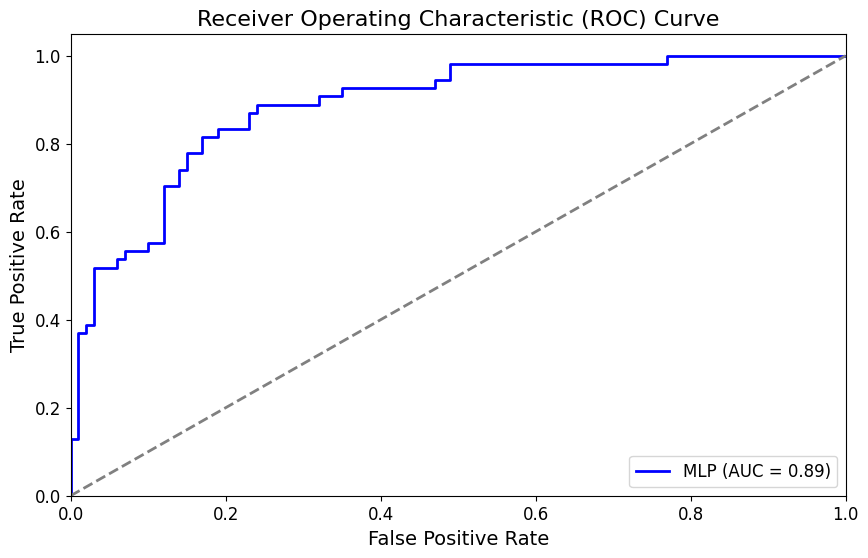

In [10]:
#Calculate probabilities for each class
probs = mlp.predict_proba(X_testTensor)

# Calculate false positive rate, true positive rate and threshold for each class
fpr, tpr, thresholds = roc_curve(y_testTensor, probs[:, 1], pos_label=1)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fpr, tpr, color='blue', lw=2, label='MLP (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="lower right", fontsize=12)
plt.show()

In [11]:

#Filter out warnings
import warnings
warnings.filterwarnings('ignore')

#Measuring time
import time

#Saving and loading models in a compressed format
from joblib import dump
from joblib import load

In [12]:
svc = load('/content/drive/MyDrive/SVM_optimised.joblib')

In [13]:
y_pred = svc.predict(X_test)

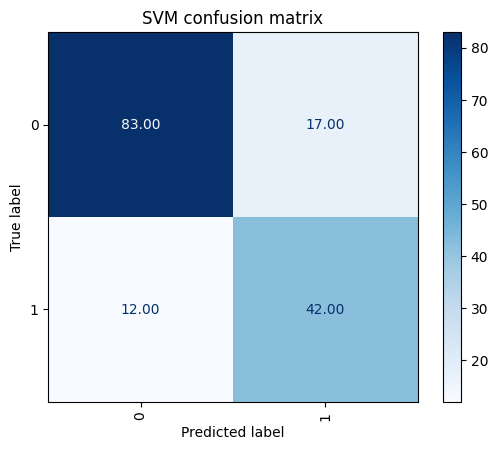

In [14]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.2f', xticks_rotation='vertical')
disp.ax_.set_title('SVM confusion matrix')
plt.show()

In [17]:
svc.score(X_test, y_test)

0.8116883116883117

In [15]:
#Calculate precision, recall, F1-score, and support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

#Print the results
print('precision', precision, '\nrecall', recall, '\nF1', f1, '\nsupport', support)

precision [0.87368421 0.71186441] 
recall [0.83       0.77777778] 
F1 [0.85128205 0.74336283] 
support [100  54]


<Figure size 640x480 with 0 Axes>

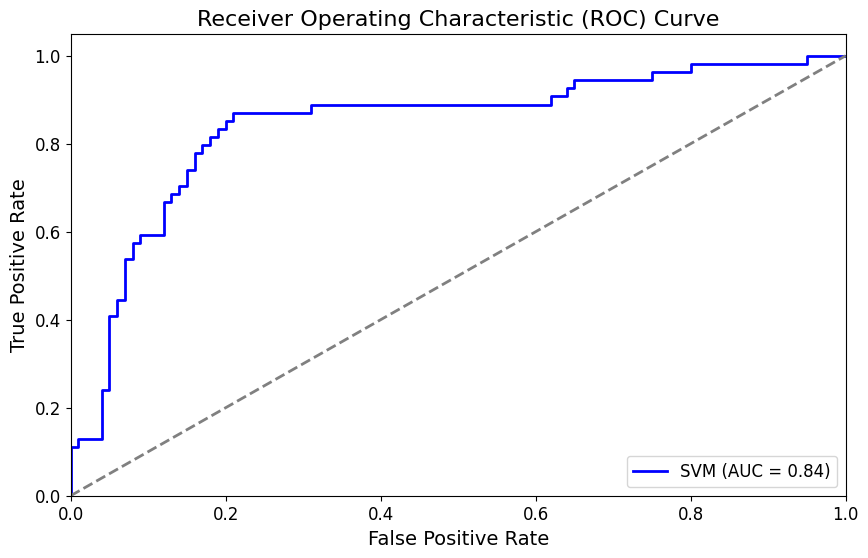

In [16]:
#Getting the best model
best_model =svc.best_estimator_

#Getting the decision scores on the test set
decision_scores = best_model.decision_function(X_test)

#Calculate false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(y_test, decision_scores)

#Calculate AUC
roc_auc = auc(fpr, tpr)

#Plotting the ROC curve
plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="lower right", fontsize=12)
plt.show()